# Roll decay test parameter sensitivity many


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
pd.set_option("display.max_rows", 200)
import matplotlib.pyplot as plt

from pylab import rcParams
rcParams['figure.figsize'] = 15, 7

import os
from scipy.optimize import curve_fit

from rolldecay.simulation import  simulate
#import rolldecay.parameter_identification as parameter_identification
import rolldecay.read_funky_ascii
import inspect
from rolldecayestimators.direct_estimator import DirectEstimator,NorwegianEstimator
from rolldecayestimators.transformers import CutTransformer, LowpassFilterDerivatorTransformer, ScaleFactorTransformer, OffsetTransformer
from rolldecay.equations_lambdify import calculate_acceleration, calculate_velocity
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

In [3]:
acii_directory_path = os.path.join(rolldecay.data_path,'project1','Ascii files')
file_names = []
for file_name in os.listdir(acii_directory_path):
    file_names.append(file_name)

In [4]:
pipeline_norwegians = {}

for file_name in file_names:
    
    ascii_file_path = os.path.join(acii_directory_path,file_name)
    df_raw = rolldecay.read_funky_ascii.read(ascii_path=ascii_file_path)[['phi']]
    
    # Exclude tests where roll is not big enough:
    if ((df_raw['phi'].max() < np.deg2rad(1)) |
        (df_raw['phi'].min() > -np.deg2rad(1))):
        continue
    
    

    lowpass_filter = LowpassFilterDerivatorTransformer(cutoff=0.5)
    scaler = ScaleFactorTransformer(scale_factor=29.565)
    cutter = CutTransformer(phi_max=np.deg2rad(8), phi_min=np.deg2rad(0.2))
    offset_transformer = OffsetTransformer()
    norwegian_estimator = NorwegianEstimator(calculate_acceleration=calculate_acceleration, simulate=simulate)
    
    steps = [
    ('filter',lowpass_filter),
    ('scaler',scaler),
    ('cutter', cutter), 
    ('offset_transformer',offset_transformer),
    ('norwegian_estimator', norwegian_estimator)]
        
    pipeline_norwegian = Pipeline(steps) # define the pipeline object.    
    pipeline_norwegian.fit(X=df_raw)
    pipeline_norwegians[file_name] = pipeline_norwegian

In [32]:
df_norwegian = pd.DataFrame()

for file_name, pipeline_norwegian in pipeline_norwegians.items():
    
    estimator = pipeline_norwegian['norwegian_estimator']
    s = pd.Series(estimator.parameters, name=file_name)
    s['score'] = estimator.score(X=estimator.X)
    s['mean_damping'] = estimator.calculate_average_linear_damping(phi_a=np.deg2rad(4))
    df_norwegian = df_norwegian.append(s)

In [33]:
df_norwegian.sort_values(by='score', ascending=False)

,d,mean_damping,omega0,score,zeta
20084871056k.14.asc,0.050670,0.035927,0.226264,0.999559,0.034426
20084871054k.12.asc,-0.059489,0.020978,0.220637,0.999220,0.022741
20084871054k.07.asc,0.067334,0.016482,0.220047,0.999213,0.014487
20084871055k.15.asc,0.198243,0.034616,0.229421,0.999123,0.028742
20084871054k.06.asc,0.230188,0.016708,0.219980,0.999051,0.009887
20084871052k.12.asc,0.192670,0.049506,0.219299,0.999031,0.043797
20084871056k.15.asc,-0.008767,0.038519,0.226461,0.998958,0.038779
20084871052k.10.asc,-0.060617,0.035491,0.218528,0.998895,0.037287
20084871052k.04.asc,0.162084,0.023578,0.219196,0.998761,0.018776
20084871055k.21.asc,0.218412,0.014913,0.220778,0.998737,0.008441


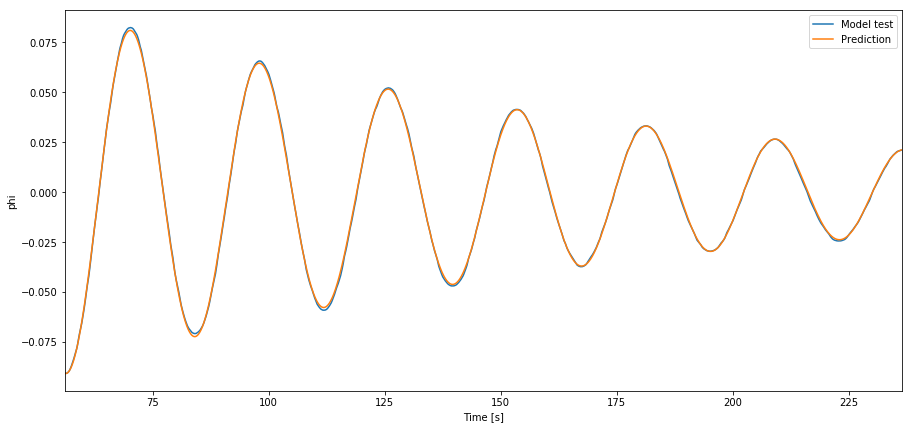

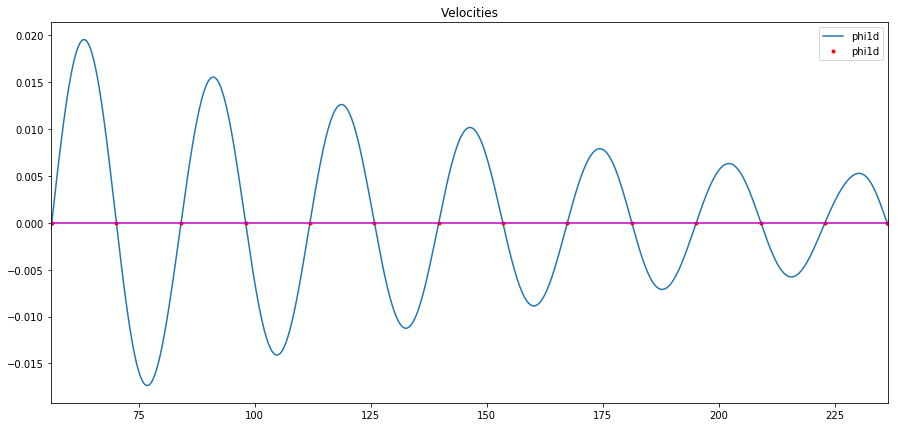

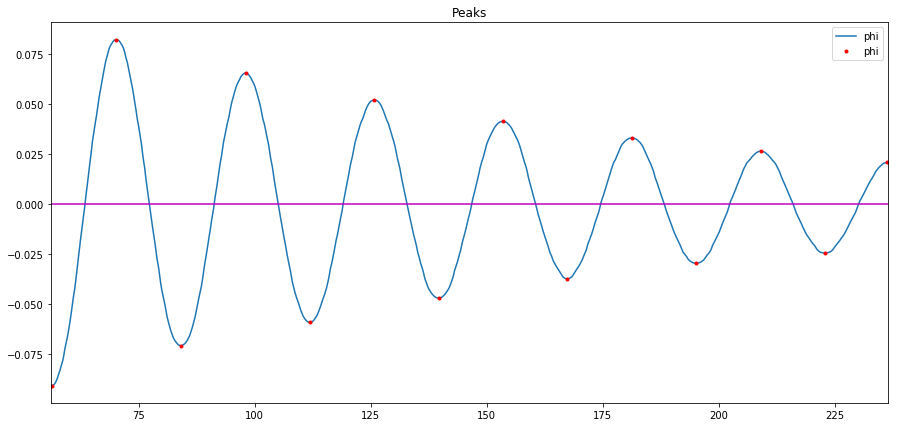

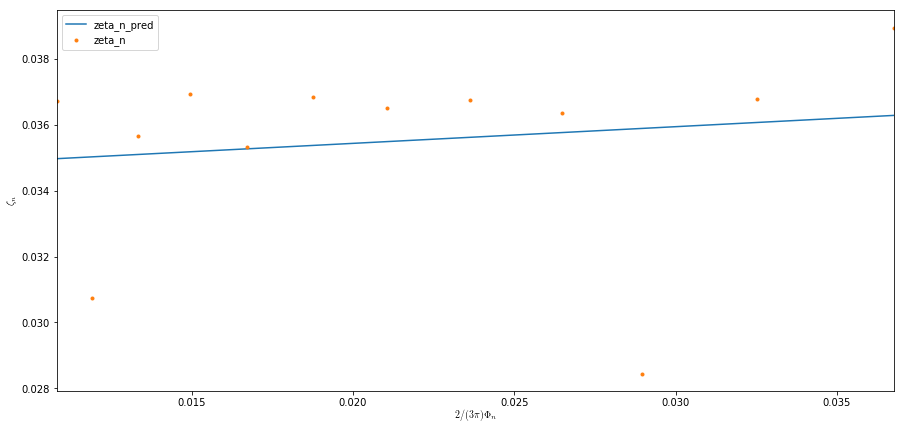

In [34]:
pipeline_norwegian = pipeline_norwegians['20084871056k.14.asc']
estimator = pipeline_norwegian['norwegian_estimator']
estimator.plot_fit()
estimator.plot_velocity()
estimator.plot_peaks()
estimator.plot_damping()

In [35]:
mask = df_norwegian['score'] > 0.99
df_norwegian_good = df_norwegian.loc[mask].copy()

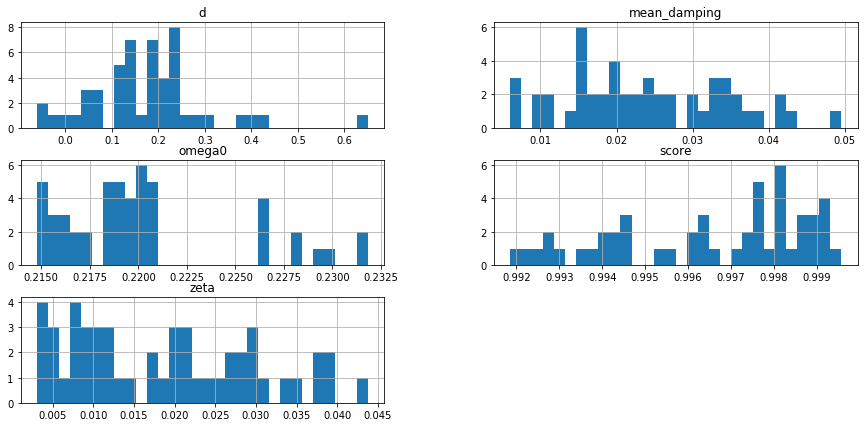

In [46]:
df_norwegian_good.hist(bins=30);

## Direct

In [37]:
pipeline_directs = {}

for file_name in file_names:
    
    ascii_file_path = os.path.join(acii_directory_path,file_name)
    df_raw = rolldecay.read_funky_ascii.read(ascii_path=ascii_file_path)[['phi']]
    
    # Exclude tests where roll is not big enough:
    if ((df_raw['phi'].max() < np.deg2rad(1)) |
        (df_raw['phi'].min() > -np.deg2rad(1))):
        continue
    
    

    lowpass_filter = LowpassFilterDerivatorTransformer(cutoff=0.5)
    scaler = ScaleFactorTransformer(scale_factor=29.565)
    cutter = CutTransformer(phi_max=np.deg2rad(8), phi_min=np.deg2rad(0.2))
    offset_transformer = OffsetTransformer()
    direct_estimator = DirectEstimator(calculate_acceleration=calculate_acceleration, simulate=simulate)
    
    steps = [
    ('filter',lowpass_filter),
    ('scaler',scaler),
    ('cutter', cutter), 
    ('offset_transformer',offset_transformer),
    ('direct_estimator', direct_estimator)]
        
    pipeline_direct = Pipeline(steps) # define the pipeline object.    
    pipeline_direct.fit(X=df_raw)
    pipeline_directs[file_name] = pipeline_direct

In [38]:
df_direct = pd.DataFrame()

for file_name, pipeline_direct in pipeline_directs.items():
    
    estimator = pipeline_direct['direct_estimator']
    s = pd.Series(estimator.parameters, name=file_name)
    s['score'] = estimator.score(X=estimator.X)
    s['mean_damping'] = estimator.calculate_average_linear_damping(phi_a=np.deg2rad(4))
    df_direct = df_direct.append(s)

In [39]:
df_direct.sort_values(by='score', ascending=False)

,d,mean_damping,omega0,score,zeta
20084871056k.14.asc,7.405932e-03,0.034948,0.226282,0.999558,3.472859e-02
20084871054k.07.asc,1.712666e-01,0.017534,0.220083,0.999333,1.245961e-02
20084871054k.11.asc,1.166103e-02,0.029302,0.219934,0.999254,2.895619e-02
20084871056k.10.asc,3.850850e-03,0.032525,0.226037,0.999234,3.241052e-02
20084871054k.12.asc,1.593405e-04,0.020658,0.221090,0.999084,2.065335e-02
20084871052k.12.asc,1.558032e-01,0.049744,0.219195,0.999015,4.512766e-02
20084871054k.06.asc,3.012935e-02,0.017061,0.220015,0.998979,1.616804e-02
20084871052k.04.asc,5.290680e-02,0.022192,0.219062,0.998841,2.062404e-02
20084871052k.10.asc,2.110438e-02,0.036385,0.218336,0.998809,3.575924e-02
20084871052k.07.asc,3.261655e-03,0.024359,0.219111,0.998741,2.426209e-02


In [40]:
mask = df_direct['score'] > 0.99
df_direct_good = df_direct.loc[mask].copy()

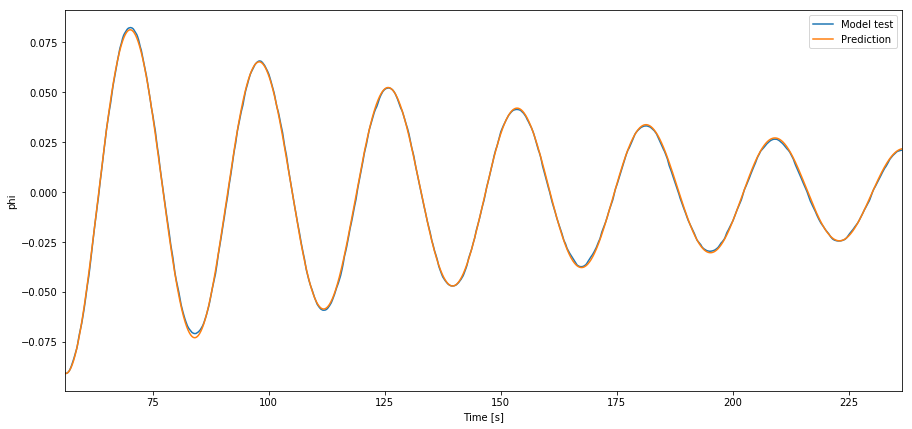

In [41]:
pipeline_direct = pipeline_directs['20084871056k.14.asc']
estimator = pipeline_direct['direct_estimator']
estimator.plot_fit()

### The two methods have similar score but different solutions...

In [42]:
df_comparison = (df_norwegian_good-df_direct_good).abs()/df_norwegian_good.abs()

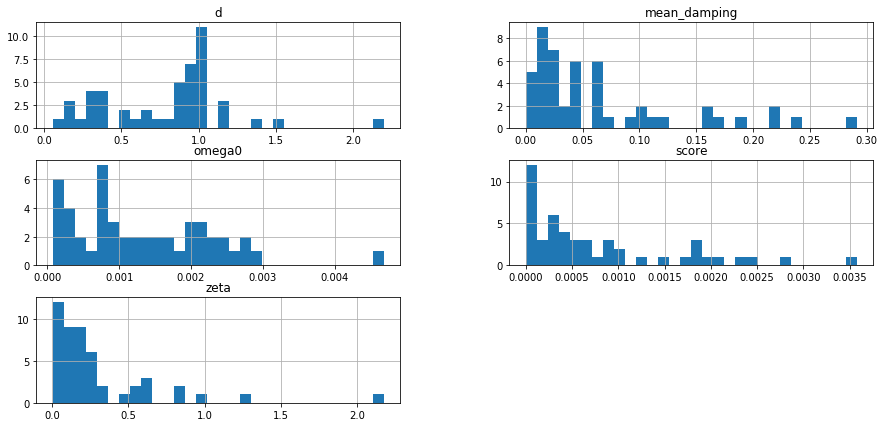

In [45]:
df_comparison.hist(bins=30);

In [47]:
df_norwegian_good.head()

,d,mean_damping,omega0,score,zeta
20084871055k.11.asc,0.037545,0.030411,0.228095,0.996421,0.029298
20084871056k.11.asc,0.028388,0.027360,0.226695,0.996242,0.026518
20084871055k.02.asc,0.185635,0.015085,0.220185,0.992546,0.009585
20084871051k.19.asc,0.242885,0.031325,0.218689,0.994152,0.024128
20084871055k.03.asc,0.194563,0.015053,0.220491,0.994676,0.009288


In [48]:
df_direct_good.head()

,d,mean_damping,omega0,score,zeta
20084871055k.11.asc,0.120173,0.032263,0.227526,0.998253,0.028702
20084871056k.11.asc,0.002528,0.026751,0.226084,0.998717,0.026677
20084871056k.12.asc,0.002259,0.030009,0.225725,0.996057,0.029942
20084871055k.02.asc,0.149578,0.015682,0.220561,0.995367,0.011250
20084871051k.19.asc,0.006192,0.027982,0.218096,0.993213,0.027799
